In [1]:
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2022-05-23 07:50:14.188936: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.2


In [2]:
# ### Load data (one file)
# file = "../data/onetrack_multicluster/pion_files/001.npy"
# event_data = np.load(file, allow_pickle=True).item()
# df = pd.DataFrame(event_data)

In [3]:
### Load data (multiple files)
n_files = 100
files = glob.glob('/usr/workspace/hip/ML4Jets/regression_images/graphs.v01-45-gaa27bcb/onetrack_multicluster/pion_files/*.npy')
df = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True).item()) for file in tqdm(files[:n_files])])
print("Dataframe has {:,} events.".format(df.shape[0]))

100%|██████████| 100/100 [03:43<00:00,  2.23s/it]


Dataframe has 1,027,804 events.


In [4]:
max_clusters = pd.DataFrame(df.cluster_E.to_list()).shape[1]
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_clusters)]))

In [23]:
dR = np.hstack(df.dR)
cluster_E = np.hstack(df.cluster_E)

In [26]:
cluster_E[cluster_E>.5].shape, cluster_E[np.logical_and(cluster_E>.5, dR<1.2)].shape

df.dR_pass.sum(), cluster_E.shape

(2768813, (2867016,))

In [4]:
### Start the dataframe of inputs 
# df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list())[0]) # just take the leading cluster E 
max_clusters = pd.DataFrame(df.cluster_E.to_list()).shape[1]
df2 = pd.DataFrame(pd.DataFrame(df.cluster_E.to_list(), columns=["cluster_e_"+str(x) for x in np.arange(max_clusters)]))

### Add track pT & truth particle E 
track_pt = np.array(df.trackPt.explode())
truth_particle_e = np.array(df.truthPartE.explode())
track_eta = np.array(df.trackEta.explode())
track_phi = np.array(df.trackPhi.explode())
track_z0 = np.array(df.trackZ0.explode())

df2["track_pt"] = track_pt
df2["track_eta"] = track_eta
df2["track_phi"] = track_phi
df2["track_z0"] = track_z0
df2["truth_particle_e"] = truth_particle_e

### Drop infs/NaNs 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

### Cluster_E > 0.5
df2 = df2[df2.cluster_e_0 > 0.5]

### Lose outliers in track pT 
df2 = df2[df2.track_pt < 5000]

### Cast as float
df2 = df2.astype('float32')

### Add the log of all energy variables
for var in df2.keys():
    if var in ["track_eta", "track_phi", "track_z0"]:
        continue
    else:
        df2['log10_'+var] = np.log10(df2[var])
    
### Do this again? 
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df2 = df2.fillna(0)

/usr/workspace/karande1/opence/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
df2.keys()

Index(['cluster_e_0', 'cluster_e_1', 'cluster_e_2', 'cluster_e_3',
       'cluster_e_4', 'cluster_e_5', 'cluster_e_6', 'cluster_e_7',
       'cluster_e_8', 'cluster_e_9', 'cluster_e_10', 'cluster_e_11',
       'cluster_e_12', 'cluster_e_13', 'cluster_e_14', 'cluster_e_15',
       'cluster_e_16', 'cluster_e_17', 'cluster_e_18', 'cluster_e_19',
       'cluster_e_20', 'cluster_e_21', 'cluster_e_22', 'cluster_e_23',
       'cluster_e_24', 'cluster_e_25', 'cluster_e_26', 'cluster_e_27',
       'cluster_e_28', 'cluster_e_29', 'cluster_e_30', 'cluster_e_31',
       'cluster_e_32', 'cluster_e_33', 'cluster_e_34', 'track_pt', 'track_eta',
       'track_phi', 'track_z0', 'truth_particle_e', 'log10_cluster_e_0',
       'log10_cluster_e_1', 'log10_cluster_e_2', 'log10_cluster_e_3',
       'log10_cluster_e_4', 'log10_cluster_e_5', 'log10_cluster_e_6',
       'log10_cluster_e_7', 'log10_cluster_e_8', 'log10_cluster_e_9',
       'log10_cluster_e_10', 'log10_cluster_e_11', 'log10_cluster_e_12',
      

In [6]:
### Inspect variables 
# sns.set(font_scale = 2)
# corr_vars = ['truth_particle_e', 'cluster_e_0', 'track_pt', 'track_eta']
# g = sns.pairplot(df2[corr_vars], diag_kind='kde')
# g.fig.set_figheight(12)
# g.fig.set_figwidth(12)

In [30]:
### Test/train split 
train = df2.sample(frac=0.8, random_state=0)
test = df2.drop(train.index)

# train_vars = [
#     'log10_cluster_e_0', 'log10_cluster_e_1',
#     'log10_cluster_e_2', 'log10_cluster_e_3', 'log10_cluster_e_4',
#     'log10_cluster_e_11', 'log10_cluster_e_12', 'log10_cluster_e_13',
#     'log10_cluster_e_14', 'log10_cluster_e_15', 'log10_cluster_e_16',
#     'log10_cluster_e_17', 'log10_cluster_e_18', 'log10_cluster_e_19',
#     'log10_cluster_e_20', 'log10_cluster_e_21', 'log10_cluster_e_22',
#     'log10_cluster_e_23', 'log10_cluster_e_24', 'log10_cluster_e_25',
#     'log10_cluster_e_26', 'log10_cluster_e_27', 'log10_cluster_e_28',
#     'log10_cluster_e_29', 'log10_cluster_e_30', 'log10_cluster_e_31', 
#     'log10_cluster_e_32', 'log10_cluster_e_33', 'log10_cluster_e_34',
#     'log10_track_pt',
#     'track_eta'
#              ]
train_vars = [
    'log10_cluster_e_0',
    'log10_track_pt',
    'track_eta'
             ]
### All clusters + track eta/phi/z0
# train_vars = [var for var in df2.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
# train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

In [31]:
### Normalize the inputs 
# sc = StandardScaler()
# train_x = sc.fit_transform(train_x)
# test_x = sc.transform(test_x)

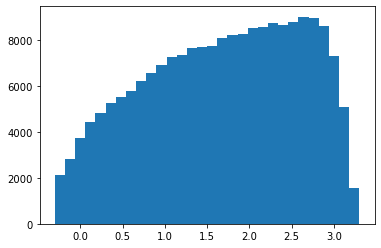

In [32]:
plt.hist(test_x[:,0], bins=30);
# plt.yscale('log');

In [33]:
def regression_model():
    model = Sequential()
    model.add(Dense(50, input_dim=train_x.shape[1], activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    return model

In [34]:
model = regression_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 50)                200       
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 5,351
Trainable params: 5,351
Non-trainable params: 0
_________________________________________________________________


In [35]:
%%time
clbk = keras.callbacks.ModelCheckpoint('./tmp/', save_best_only=True)
history = model.fit(
    train_x,
    train_y,
    batch_size=2048,
    validation_split=0.2,
    verbose=2, epochs=100,
    callbacks=[clbk])

Epoch 1/100
314/314 - 1s - loss: 0.1059 - val_loss: 0.0448
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 2/100
314/314 - 1s - loss: 0.0392 - val_loss: 0.0362
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 3/100
314/314 - 1s - loss: 0.0361 - val_loss: 0.0367
Epoch 4/100
314/314 - 1s - loss: 0.0353 - val_loss: 0.0358
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 5/100
314/314 - 1s - loss: 0.0348 - val_loss: 0.0350
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 6/100
314/314 - 1s - loss: 0.0346 - val_loss: 0.0344
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 7/100
314/314 - 1s - loss: 0.0345 - val_loss: 0.0344
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 8/100
314/314 - 1s - loss: 0.0340 - val_loss: 0.0341
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 9/100
314/314 - 1s - loss: 0.0338 - val_loss: 0.0333
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 10/100
314/314 - 1s - loss: 0.0335 - val_loss: 0.0345
Epoch 11/100
314/314 - 1s

In [36]:
model.evaluate(test_x, test_y, batch_size=2048)

99/99 [==============================] - 0s 1ms/step - loss: 0.0304


0.03043142519891262

In [37]:
model = keras.models.load_model('./tmp/')
model.evaluate(test_x, test_y, batch_size=2048)

99/99 [==============================] - 0s 1ms/step - loss: 0.0304


0.03039892390370369

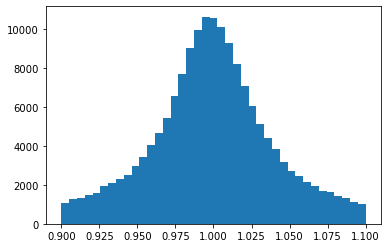

In [38]:
### Evaluate performance on test set 
test['nn_score'] = model.predict(test_x)
plt.hist((10**test.nn_score)/(10**test.log10_truth_particle_e), bins=np.linspace(0.9,1.1,40));

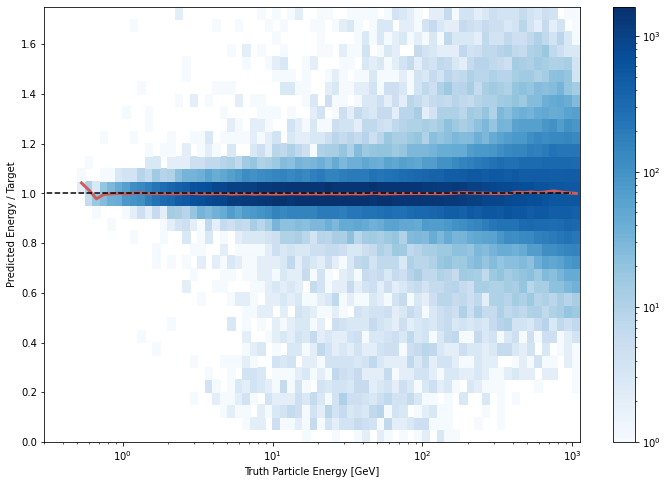

In [39]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e

y = (10**test.nn_score)/(10**test.log10_truth_particle_e)

xbin = [10**exp for exp in np.arange(-1.05, 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target')
plt.colorbar()
plt.show()
# np.savez('pub_note_results/response_median_simple.npz', response_median=profileXMed, xcenter=xcenter)

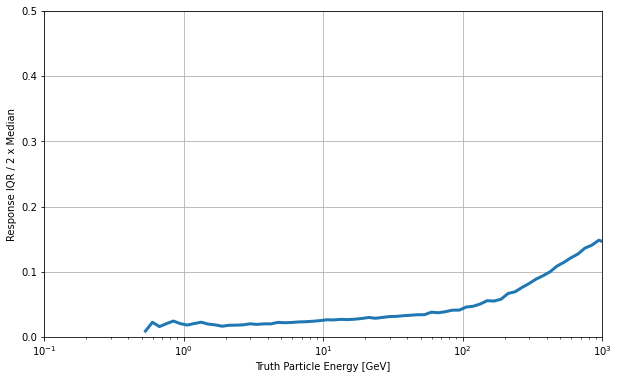

In [40]:
### IQR plot 

def iqrOverMed(x):
    # get the IQR via the percentile function
    # 84 is median + 1 sigma, 16 is median - 1 sigma
    q84, q16 = np.percentile(x, [84, 16])
    iqr = q84 - q16
    med = np.median(x)
    return iqr / (2*med)

resolution_single = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution_single, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');
plt.grid()
plt.show()
# np.savez('pub_note_results/iqr_simple.npz', iqr=resolution, xcenter=xcenter)

In [41]:
### Test/train split 
train = df2.sample(frac=0.8, random_state=0)
test = df2.drop(train.index)

train_vars = [
    'log10_cluster_e_0', 'log10_cluster_e_1',
    'log10_cluster_e_2', 'log10_cluster_e_3', 'log10_cluster_e_4',
    'log10_cluster_e_11', 'log10_cluster_e_12', 'log10_cluster_e_13',
    'log10_cluster_e_14', 'log10_cluster_e_15', 'log10_cluster_e_16',
    'log10_cluster_e_17', 'log10_cluster_e_18', 'log10_cluster_e_19',
    'log10_cluster_e_20', 'log10_cluster_e_21', 'log10_cluster_e_22',
    'log10_cluster_e_23', 'log10_cluster_e_24', 'log10_cluster_e_25',
    'log10_cluster_e_26', 'log10_cluster_e_27', 'log10_cluster_e_28',
    'log10_cluster_e_29', 'log10_cluster_e_30', 'log10_cluster_e_31', 
    'log10_cluster_e_32', 'log10_cluster_e_33', 'log10_cluster_e_34',
    'log10_track_pt',
    'track_eta'
             ]
# train_vars = [
#     'log10_cluster_e_0',
#     'log10_track_pt',
#     'track_eta'
#              ]
### All clusters + track eta/phi/z0
# train_vars = [var for var in df2.keys() if var.startswith('log10') and var != 'log10_truth_particle_e']
# train_vars += ['track_eta', 'track_phi', 'track_z0']

train_x = train[train_vars].values
train_y = train['log10_truth_particle_e'].values
test_x = test[train_vars].values
test_y = test['log10_truth_particle_e'].values

In [42]:
model_allCluster = regression_model()
model_allCluster.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                1600      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 6,751
Trainable params: 6,751
Non-trainable params: 0
_________________________________________________________________


In [43]:
%%time
clbk = keras.callbacks.ModelCheckpoint('./tmp/', save_best_only=True)
history = model_allCluster.fit(
    train_x,
    train_y,
    batch_size=2048,
    validation_split=0.2,
    verbose=2, epochs=100,
    callbacks=[clbk])

Epoch 1/100
314/314 - 1s - loss: 0.1793 - val_loss: 0.0366
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 2/100
314/314 - 1s - loss: 0.0329 - val_loss: 0.0302
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 3/100
314/314 - 1s - loss: 0.0296 - val_loss: 0.0281
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 4/100
314/314 - 1s - loss: 0.0273 - val_loss: 0.0267
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 5/100
314/314 - 1s - loss: 0.0260 - val_loss: 0.0259
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 6/100
314/314 - 1s - loss: 0.0252 - val_loss: 0.0245
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 7/100
314/314 - 1s - loss: 0.0247 - val_loss: 0.0244
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 8/100
314/314 - 1s - loss: 0.0244 - val_loss: 0.0254
Epoch 9/100
314/314 - 1s - loss: 0.0238 - val_loss: 0.0238
INFO:tensorflow:Assets written to: ./tmp/assets
Epoch 10/100
314/314 - 1s - loss: 0.0237 - val_loss: 0.0238
INFO:tensorflow:Assets wr

In [44]:
model_allCluster.evaluate(test_x, test_y, batch_size=2048)

99/99 [==============================] - 0s 1ms/step - loss: 0.0214


0.02138214185833931

In [45]:
model_allCluster = keras.models.load_model('./tmp/')
model_allCluster.evaluate(test_x, test_y, batch_size=2048)

99/99 [==============================] - 0s 1ms/step - loss: 0.0211


0.021059224382042885

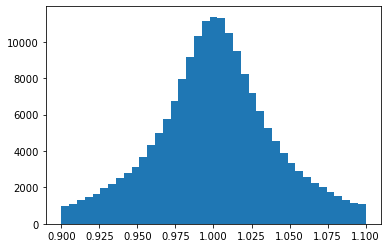

In [46]:
### Evaluate performance on test set 
test['nn_score'] = model_allCluster.predict(test_x)
plt.hist((10**test.nn_score)/(10**test.log10_truth_particle_e), bins=np.linspace(0.9,1.1,40));

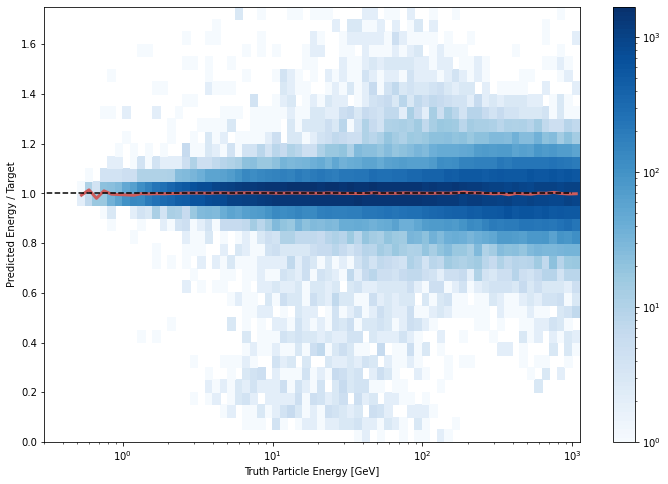

In [47]:
### Response median plot 
import scipy.stats as stats
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

x = test.truth_particle_e

y = (10**test.nn_score)/(10**test.log10_truth_particle_e)

xbin = [10**exp for exp in np.arange(-1.05, 3.1, 0.05)]
ybin = np.arange(0., 3.1, 0.05)
xcenter = [(xbin[i] + xbin[i+1]) / 2 for i in range(len(xbin)-1)]
profileXMed = stats.binned_statistic(
    x, y, bins=xbin, statistic='median').statistic

c_map = ListedColormap(sns.color_palette("Blues", n_colors=100).as_hex())
fig = plt.figure(figsize=(12,8))
fig.patch.set_facecolor('white')
plt.hist2d(x, y, bins=[xbin, ybin], norm=LogNorm(),zorder = -1, cmap=c_map);
plt.plot(np.array(xcenter), np.array(profileXMed), color='indianred', linewidth=3)
plt.plot([0.1, 1000], [1, 1], linestyle='--', color='black');
plt.xscale('log')
plt.ylim(0, 1.75)
plt.xlim(0.3, )
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Predicted Energy / Target')
plt.colorbar()
plt.show()
# np.savez('pub_note_results/response_median_simple.npz', response_median=profileXMed, xcenter=xcenter)

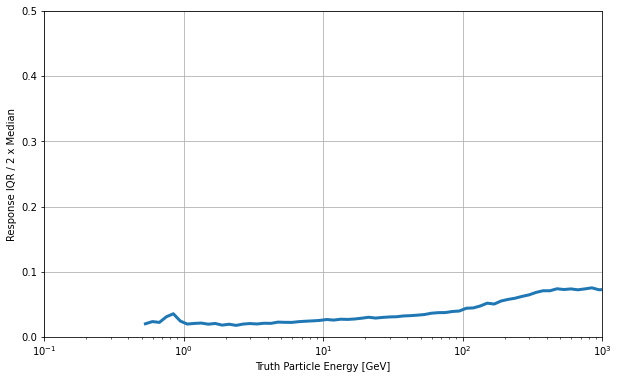

In [48]:
### IQR plot 
resolution_allCluster = stats.binned_statistic(x, y, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution_allCluster, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');
plt.grid()
plt.show()
# np.savez('pub_note_results/iqr_simple.npz', iqr=resolution, xcenter=xcenter)

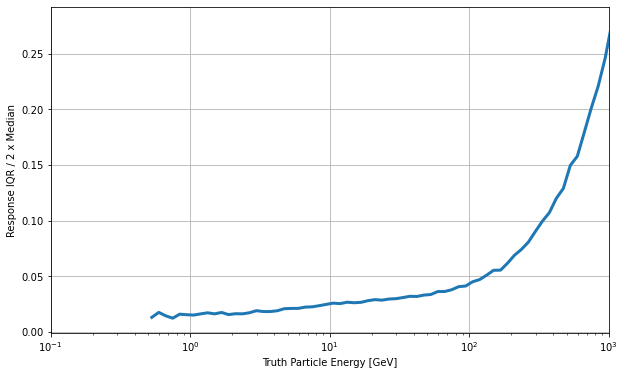

In [49]:
x_cut = test.truth_particle_e # test.loc[np.abs(test.track_eta)<1, 'truth_particle_e']
pred_cut = test.track_pt*np.cosh(test.track_eta)
y_cut = (pred_cut)/(x_cut)

resolution_gt = stats.binned_statistic(x_cut, y_cut, bins=xbin,statistic=iqrOverMed).statistic

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.plot(xcenter, resolution_gt, linewidth=3)
plt.xscale('log')
plt.xlim(0.1, 1000)
# plt.ylim(0,0.1)
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');
plt.grid()
plt.show()

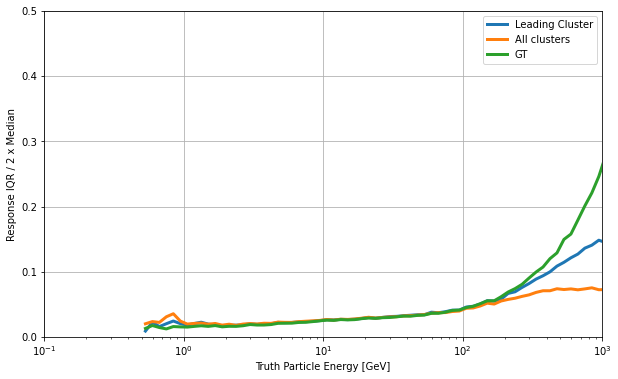

In [51]:
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')

plt.plot(xcenter, resolution_single, linewidth=3, label='Leading Cluster')
plt.plot(xcenter, resolution_allCluster, linewidth=3, label='All clusters')
plt.plot(xcenter, resolution_gt, linewidth=3, label='GT')
plt.xscale('log')
plt.xlim(0.1, 1000)
plt.ylim(0,0.5)
plt.legend()
plt.xlabel('Truth Particle Energy [GeV]')
plt.ylabel('Response IQR / 2 x Median');
plt.grid()
plt.show()